### pips

In [ ]:
!pip install -q --upgrade pip
!pip uninstall -y fastai torch torchvision torchaudio gcsfs fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.6 MB/s eta 0:00:00
Found existing installation: fastai 2.7.19
Uninstalling fastai-2.7.19:
  Successfully uninstalled fastai-2.7.19
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: gcsfs 2025.3.0
Uninstalling gcsfs-2025.3.0:
  Successfully uninstalled gcsfs-2025.3.0
Found existing installation: fsspec 2025.3.0
Uninstalling fsspec-2025.3.0:
  Successfully uninstalled fsspec-2025.3.0


In [ ]:
!pip install -q torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1 \
    --index-url https://download.pytorch.org/whl/cu118

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'lit' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lit'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [ ]:
!pip install -q fsspec==2025.3.0 gcsfs==2025.3.0

In [ ]:
!pip install -q \
    bitsandbytes==0.46.0 \
    transformers==4.52.4 \
    accelerate==1.8.1 \
    datasets==3.6.0 \
    sentence-transformers==4.1.0 \
    chromadb==1.0.13 \
    langchain==0.3.26 \
    langchain-community==0.3.26 \
    langchain-huggingface \
    tqdm==4.67.1

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 2.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 2.7.1 which is incompatible.


### import




In [ ]:
from torch import cuda, bfloat16
import torch, transformers
import torchvision
from transformers import AutoTokenizer, BitsAndBytesConfig, pipeline

torchvision.disable_beta_transforms_warning()
DEVICE = f"cuda:{cuda.current_device()}" if cuda.is_available() else "cpu"

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.11/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might invo

In [ ]:
import sys
print(transformers.__version__, sys.executable)

4.52.4 /usr/bin/python3


In [ ]:
import bitsandbytes as bnb, importlib, os
print(bnb.__version__)
!ldconfig -p | grep cusparse | head -n 3

0.46.0
	libcusparse.so.12 (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libcusparse.so.12
	libcusparse.so (libc6,x86-64) => /usr/local/cuda/targets/x86_64-linux/lib/libcusparse.so


# Generator

## Квантизация

In [ ]:
# Конфигурация квантования
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                          # включаем 4-битное квантование
    bnb_4bit_quant_type="nf4",                  # тип квантования NF4
    bnb_4bit_use_double_quant=True,             # двойное квантование для уменьшения объёма
    bnb_4bit_compute_dtype=torch.float16        # вычисления в float16
)

print("Загружаем модель …")
model = transformers.AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-8B",
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,  # передаём явно тип
    trust_remote_code=True      # может понадобиться для Qwen
)

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B", use_fast=True)

llm_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
    device_map="auto",
)


Загружаем модель …


config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
llm_pipeline('who is the president of USA?',
             max_new_tokens=200, temperature=0.7, top_p=0.9)

[{'generated_text': "who is the president of USA??\nThe current president of the United States is Joe Biden. He took office on January 20, 2021, following the 2020 presidential election. Prior to becoming president, he served as a U.S. Senator from Pennsylvania and as the 47th Vice President of the United States under Barack Obama from 2009 to 2017. Biden is a member of the Democratic Party and has been a prominent figure in American politics for several decades. \n\nIf you're asking about the president at a specific time or in a different context, please provide more details so I can give a more accurate response. \n\nAlso, please note that the United States has had 46 presidents since the country's founding, with each serving a term or terms in office. The current president is the 46th in the sequence, with Joe Biden being the 46th president. \n\nIf you have any other questions about the U.S."}]

# Данные

In [ ]:
from datasets import load_dataset
from langchain.docstore.document import Document
from tqdm.notebook import tqdm

## Чтение и загрузка

In [ ]:
qa_ds = load_dataset("enelpol/rag-mini-bioasq", "question-answer-passages")
passages_ds = load_dataset("enelpol/rag-mini-bioasq", "text-corpus")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/187k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4012 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/707 [00:00<?, ? examples/s]

test-00000-of-00001.parquet:   0%|          | 0.00/35.3M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/40181 [00:00<?, ? examples/s]

In [ ]:
qa_ds

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'id', 'relevant_passage_ids'],
        num_rows: 4012
    })
    test: Dataset({
        features: ['question', 'answer', 'id', 'relevant_passage_ids'],
        num_rows: 707
    })
})

In [ ]:
passages_ds

DatasetDict({
    test: Dataset({
        features: ['passage', 'id'],
        num_rows: 40181
    })
})

In [ ]:
database = [
    Document(page_content=doc["passage"],
             metadata={"id": doc["id"]}) for doc in tqdm(passages_ds["test"])
]

  0%|          | 0/40181 [00:00<?, ?it/s]

## Деление на фрагменты

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter  # рекурсивно разбивает длинный текст на более мелкие фрагменты (chunks).

splitter = RecursiveCharacterTextSplitter(
           chunk_size=512,   #фрагменты будут не длиннее chunk_size СИМВОЛОВ
           chunk_overlap=100)

docs = splitter.split_documents(database)
print("Чанков:", len(docs))

Чанков: 160190


# Создание векторной базы

In [ ]:
from pathlib import Path

from langchain.document_loaders import TextLoader  # загружает текстовые файлы и превращает их в объекты Document для LangChain.
from langchain_huggingface import HuggingFaceEmbeddings  # оборачивает модели из HuggingFace для получения эмбеддингов текста.
from langchain.vectorstores import Chroma  # векторное хранилище Chroma: сохраняет и ищет эмбеддинги.

In [ ]:
embedding = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2", #модель считающая эмбеддинги фрагментов
    model_kwargs={"device": "cuda"},
)

vectordb = Chroma.from_documents(
    documents=docs,
    embedding=embedding,
    persist_directory = "chroma_ragmini"  # папка для хранения векторной базы
)
vectordb.persist()  #записывает всё в папку

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
/tmp/ipython-input-527829968.py:11: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()  #записывает всё в папку


**Проверка длины в токенах**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs)]

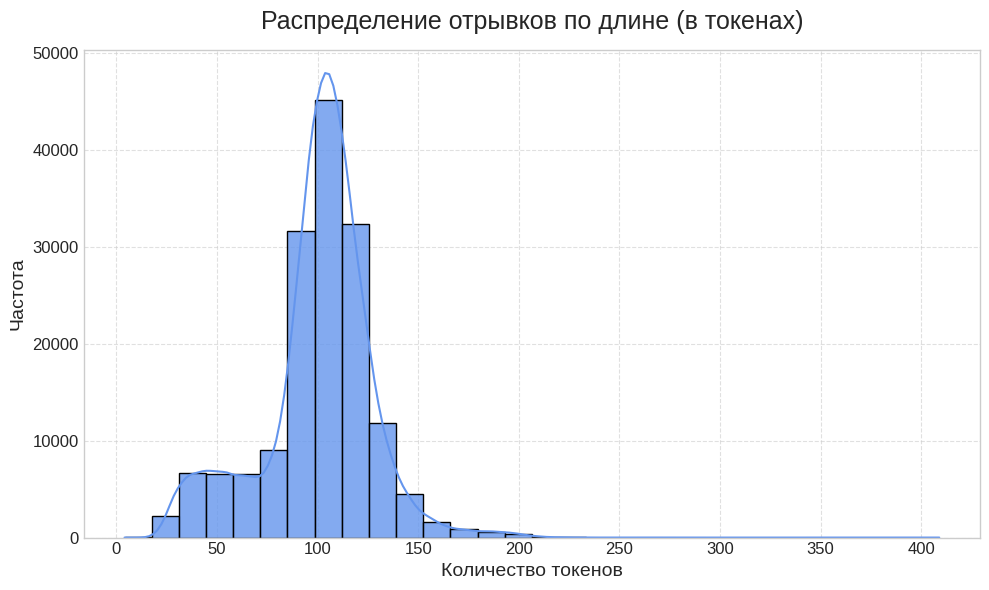

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, kde=True, color="cornflowerblue", edgecolor="black", alpha=0.8)

plt.title("Распределение отрывков по длине (в токенах)", fontsize=18, pad=15)
plt.xlabel("Количество токенов", fontsize=14)
plt.ylabel("Частота", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(visible=True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
max(lengths)

409

# Сборка цепочки RetrievalQA

In [ ]:
from transformers import GenerationConfig
from langchain_huggingface import HuggingFacePipeline  # использует HuggingFace Transformers pipeline как LLM-модуль в LangChain.
from langchain.chains import RetrievalQA  # готовая цепочка «поиск + генерация ответа» (Retrieval-augmented QA).
from langchain import PromptTemplate

In [ ]:
# Шаблон запроса с явной инструкцией
custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""Use the following pieces of context to answer the question at the end.
If you don't know the answer, say you don't know.
Answer shortly. Do not explain.

Context:
{context}

Question: {question}
Short Answer:"""
)

In [ ]:
llm = HuggingFacePipeline(
    pipeline=llm_pipeline,
    model_kwargs={
        "max_new_tokens": 128,
        "temperature": 0.1,
        "do_sample": False
    }
)


retriever = vectordb.as_retriever(search_kwargs={"k": 3})

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": custom_prompt}
)

In [ ]:
question = "What is the applicability of the No Promoter Left Behind method?"
response = qa_chain.invoke(question)

print("Инструкция:\n", response["result"])
# print('\n\nИспользуемые тексты:\n')
# for doc in response["source_documents"]:
#     print('Document:')
#     print(doc.page_content[:150], "…", end="\n\n\n")

Инструкция:
 Use the following pieces of context to answer the question at the end.
If you don't know the answer, say you don't know. 
Answer in ONE short sentence. Do not explain.

Context:
Promoters have diverse regulatory architectures and thus activate genes 
differently. For example, some have a TATA-box, many others do not. Even the 
ones with it can differ in its position relative to the transcription start site 
(TSS). No Promoter Left Behind (NPLB) is an efficient, organism-independent 
method for characterizing such diverse architectures directly from 
experimentally identified genome-wide TSSs, without relying on known promoter

for the lack of mock control data, thus reducing the experimental cost and 
producing more accurate results.

Question: What is the applicability of the No Promoter Left Behind method?
Short Answer: The No Promoter Left Behind method is applicable for characterizing diverse promoter architectures across different organisms without the need for mock c

# Валидация

In [ ]:
def get_short_answer(response):
    docs_id = [doc.metadata['id'] for doc in response['source_documents']]
    docs_id = list(set(docs_id))
    res = response['result'].split('Short Answer:')[1]
    res = res.split('\n')[0]
    return res, docs_id

In [ ]:
hit_rate3 = []
for i in tqdm(range(25)):
    question, answer, s, best_passage_ids = qa_ds['test'][i].values()
    response = qa_chain.invoke(question)
    model_answer, model_passages = get_short_answer(response)

    is_relevant = any([model_passage in best_passage_ids for model_passage in model_passages])
    hit_rate3.append(int(is_relevant))
    print(f'\nКонтекст {"НЕ" if not is_relevant else ""} актуален')
    print(f"\nВопрос: {question}")
    print(f"Ожидаемый ответ: {answer}")
    print(f"Ответ модели: {model_answer}")

  0%|          | 0/25 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Контекст НЕ актуален

Вопрос: Is capmatinib effective for glioblastoma?
Ожидаемый ответ: No. Combination of capmatinib buparlisib resulted in no clear activity in patients with recurrent PTEN-deficient glioblastoma.
Ответ модели:  The given context does not mention capmatinib. Based on the provided information, there is no evidence to support its effectiveness for glioblastoma. The context discusses other drugs like bevacizumab, cilengitide, enzastaurin, dasatinib, vandetanib, temsirolimus, and cediranib, but capmatinib is not referenced.

Контекст  актуален

Вопрос: Describe the mechanism of action of ibalizumab.
Ожидаемый ответ: Ibalizumab is a humanized monoclonal antibody that acts as post-attachment inhibitor by binding CD4 2nd domain of T lymphocyte and preventing HIV connection to CCR5 or CXCR4. It has been recently approved by Food and Drug Administration as a new intravenous antiretroviral agent for heavily treated HIV adults with multi -drug resistant infection.
Ответ модели

In [ ]:
import numpy as np
print(f'Значение Hit Rate 3 : {np.mean(hit_rate3).item() :.1%}')

Значение Hit Rate 3 : 84.0%


#**Результаты**
* создана RAG-система на базе модели `Qwen3-8B` с 4-битным квантованием
* реализован поиск релевантных документов через Chroma
* достигнуто  84% Hit Rate 3, т.е хотя бы один из 3 наших документов является актуальным.(21 из 25)
* несмотря на ошибки в извлечении документов, модель Qwen кое-где продолжала давать правильные ответы

